# Importar bibliotecas

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)# Removendo notações científicas

import requests, json
from Conexão_Banco_de_Dados_Oracle import conectar_bd
from pycep_correios import get_address_from_cep, WebService

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=False) # Removendo notações científicas
from datetime import datetime
from tqdm import tqdm # Barprogress
import os

# Remover warnings dos kernels
import warnings
warnings.filterwarnings('ignore')

# Conectar ao banco de dados (cursor)

In [ ]:
conn = conectar_bd()
cursor = conn.cursor()

# Extração de dados

In [ ]:
# Função de extração de dados do CNPJ
def _dados_cnpj(cnpj):
    return json.loads(requests.get(f'https://thecollector.linkana.com/companies?cnpj=eq.{cnpj}&limit=1%27').text)[0]

# Buscando informações de geolocalização
def busca_geolocation(cep):
    try:
        # Ajustar para parametro de pesquisa URL
        '''
        Obs: Foi acrescentado o replace para Bonfim Paulista pois era uma exceção que estava ocasionando erros "desenecessários"
        '''
        r = lambda x: x.replace('Bonfim Paulista (Ribeirão Preto)', 'Ribeirão Preto').replace(' ', '+')

        URL = "https://nominatim.openstreetmap.org/search?format=json&addressdetails=1&country=$brazil&state=${}&city=${}&limit=1"
        infos = get_address_from_cep(cep, webservice=WebService.CORREIOS)
        dados_cep = json.loads(requests.get(URL.format(infos['uf'], r(infos['cidade']))).text)[0]

        return (dados_cep['lat'], dados_cep['lon'], dados_cep['importance'], dados_cep['address']['state_district'])
    except:
        return (np.nan, np.nan, np.nan, np.nan)

In [ ]:
# Teste função de geolocalização
busca_geolocation('44025930')

In [ ]:
def obter_dados():
    # Dados cadastrais
    cons_empresas_cadastradas = '''
    SELECT 
        a.CODEMPRESA, a.RAZAOSOCIAL, a.NOMEFANTASIA, 
        d.CEP, d.NUMCNPJCPF
    FROM HINOERP_BIO.GEEMPRESA a
        LEFT JOIN HINOERP_BIO.GEEMPRESAPARAMESTAB b
            ON a.CODEMPRESA = b.CODEMPRESA
        LEFT JOIN HINOERP_BIO.GEENDEMPRESA c
            ON a.CODEMPRESA = c.CODEMPRESA
        LEFT JOIN HINOERP_BIO.GEENDERECO d
            ON c.CODENDERECO = d.CODENDERECO
        WHERE TIPOEMPRESA = 'C' AND LENGTH(d.NUMCNPJCPF) = 14
    '''
    df_empresas_cadastradas = pd.read_sql(cons_empresas_cadastradas, conn)

    # Retornando data de cadastro das empresas
    cons = '''
    SELECT e.DATALOG as DATACADASTRO, PARA AS CODEMPRESA
    FROM HINOERP_BIO.GELOG E
    LEFT JOIN HINOERP_BIO.GELOGDET b
    ON E.CODLOG = b.CODLOG
    WHERE TABELA = 'GEEMPRESA' AND CAMPO = 'Cód. Empresa' AND DE IS NULL
    '''
    datas_cadastros = pd.read_sql(cons, conn)
    datas_cadastros['CODEMPRESA'] = datas_cadastros['CODEMPRESA'].astype(int)

    # Merge das informações
    df_empresas_cadastradas = df_empresas_cadastradas.merge(datas_cadastros, on='CODEMPRESA', how='left')

    # Dados financeiros
    cons_dados_financeiros = '''
    SELECT 
        e.CODEMPRESA, 
        SUM(e.VALORORIGINAL) AS TOTALVENDAS, 
        AVG(e.VALORJUROS) AS MEDIAJUROS, 
        AVG(e.DATALIQUIDACAO - e.DATAVENCIMENTO) AS DIASATRASO
    FROM HINOERP_BIO.FITITULOS e
    WHERE e.INDICENFSAIDA IS NOT NULL
    GROUP BY CODEMPRESA
    '''

    df_titulos = pd.read_sql(cons_dados_financeiros, conn)

    # Unindo as informações
    df = df_empresas_cadastradas.merge(df_titulos, on='CODEMPRESA', how='left').fillna(0)
    df.index = [i for i in range(df.shape[0])]

    # Criação de um dicionário auxiliar
    dict_aux = {
        'Data Abertura CNPJ': [],
        'Capital Social': [],
        'Natureza Jurídica': [],
        'Porte': [],
        "CNAE's": [],
        "Latitude": [],
        "Longitude": [],
        "NvlImportanciaGEO": [],
        "Região": []
    }

    # Alimentando o dicionário auxiliar
    for i in tqdm(range(df.shape[0])):
        dados_consulta_cnpj = _dados_cnpj(df['NUMCNPJCPF'][i])
        lat, lon, importance, regiao = busca_geolocation(dados_consulta_cnpj['cep'])

        # Dados geolocalização
        dict_aux['Latitude'].append(lat)
        dict_aux['Longitude'].append(lon)
        dict_aux['NvlImportanciaGEO'].append(importance)
        dict_aux['Região'].append(regiao)

        # Dados CNPJ
        dict_aux['Data Abertura CNPJ'].append(dados_consulta_cnpj['data_inicio_atividade'])
        dict_aux['Capital Social'].append(str(dados_consulta_cnpj['capital_social'])[:-2])
        dict_aux['Natureza Jurídica'].append(dados_consulta_cnpj['natureza_juridica'])
        dict_aux['Porte'].append(dados_consulta_cnpj['cod_porte_empresa'])
        cnaes = [dados_consulta_cnpj['cnae_fiscal']]
        if dados_consulta_cnpj['cnaes_secundarios'] != None:
            cnaes = cnaes + dados_consulta_cnpj['cnaes_secundarios']
        dict_aux["CNAE's"].append(cnaes)

    # Transformando o DF auxiliar em objeto Pandas e concatenando com o DF de infos baixadas
    df_aux = pd.DataFrame.from_dict(dict_aux)
    df = pd.concat([df, df_aux], axis=1)
    
    # Salvando o arquivo
    df.to_csv(arquivo, sep=';', encoding='ISO-8859-1', index=False)
    
# Check se existe o arquivo
arquivo = 'base_dados.csv'
if not (arquivo in os.listdir()):
    obter_dados()

df = pd.read_csv(arquivo, sep=';', encoding='ISO-8859-1')

#Removendo colunas de identificação dos clientes
df = df.drop(['RAZAOSOCIAL', 'NOMEFANTASIA', 'NUMCNPJCPF'], axis=1)
print('Dataframe lido com sucesso !')

# EDA - Análise Exploratória de Dados

- <b> Conhecendo nossos dados.

In [ ]:
df.head()

In [ ]:
print(df.shape)
df.isnull().sum()

Resolvi por excluir as amostras com dados missing pelos seguintes motivos:
- poucos dados missing;
- os dados realmente não estavam disponíveis no sistema de coleta de dados 

In [ ]:
df = df.dropna()
df.shape

- <strong>Cardinalidade das variáveis<br><strong>
    
Esta métrica nos ajuda a entender quão dispostos os valores estão em um conjunto.<br>
Sendo assim, uma medida importante pois quanto maior a cardinalidade (maior número de valores únicos), menor será a probabilidade que o modelo consiga generalizar as predições.

In [ ]:
data = (df.nunique() / df.shape[0]) * 100
plt.figure(figsize=(20,4))
sns.barplot(x=data.index, y=data.values)
plt.xticks(rotation = 45)
plt.show()

Agora, iremos tratar as colunas com cardinalidade alta e moderada/alta

In [ ]:
baixa_card = data[data <= 25].index
mod_baixa_card = data[(data > 25) & (data <= 50)].index
mod_alta_card = data[(data > 50) & (data <= 75)].index
alta_card = data[data > 75].index

### Features de cardinalidade moderada/alta

In [ ]:
display(df[mod_alta_card].head(4))
df[mod_alta_card].dtypes

- [DATACADASTRO] - Datetime (object)

In [ ]:
df['DATACADASTRO'].value_counts()

Existe um dado incorreto (0), que será substituido pela data coletada manualmente (ERP).<br>
Em seguida, irei substituir esta variávei por uma nova variável correspondente à quantos meses o cliente está cadastrado.

In [ ]:
df['DATACADASTRO'] = df['DATACADASTRO'].replace('0', '2021-01-10 00:00:01')
df['DATACADASTRO'] = pd.to_datetime(df['DATACADASTRO'], format='%Y-%m-%d %H:%M:%S')
df['MesesAtividade'] = (datetime.today() - df['DATACADASTRO']).dt.days / 30
df = df .drop('DATACADASTRO', axis=1)

Ao tratar a variável de vendas apenas como um total, pode ser que acabemos classificando um cliente recente com bom volume de compras no mesmo nicho que um cliente com baixo volume de compras porém a muito mais tempo cadastrado, então, para não penalisar o primeiro, criarei mais uma feature que contará com a média do faturamento mensal desde o cadastro do mesmo. Exemplo:
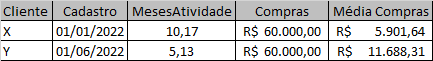

In [ ]:
df['ComprasMes'] = df['TOTALVENDAS'] / df['MesesAtividade']
total_compras = df['TOTALVENDAS'] # Armazenando caso seja necessário futuramente
df = df.drop('TOTALVENDAS', axis=1)
mod_alta_card = ['ComprasMes', 'DIASATRASO', 'MesesAtividade']

In [ ]:
df[mod_alta_card].describe()

- [ComprasMes] - Float

In [ ]:
plt.figure(figsize=(20,4))
sns.histplot(df['ComprasMes'][df['ComprasMes'] > df['ComprasMes'].median()], color='orange')
plt.xticks(list(range(0,int(df['ComprasMes'].max()),5000)), rotation='45')
plt.plot()

Vamos dividir a variável (contínua) em classes:
- de 0 - 1000
- de 1000 - 2000
- de 2000 - 5000
- de 5000 - 10000
- de 10000 - 20000
- acima de 20000

In [ ]:
df['ComprasMes'][(df['ComprasMes'] <= 1000)] = 0
df['ComprasMes'][(df['ComprasMes'] > 1000) & (df['ComprasMes'] <= 2000)] = 1
df['ComprasMes'][(df['ComprasMes'] > 2000) & (df['ComprasMes'] <= 5000)] = 2
df['ComprasMes'][(df['ComprasMes'] > 5000) & (df['ComprasMes'] <= 10000)] = 3
df['ComprasMes'][(df['ComprasMes'] > 10000) & (df['ComprasMes'] <= 20000)] = 4
df['ComprasMes'][(df['ComprasMes'] > 20000)] = 5

- [DIASATRASO] - Float

In [ ]:
dias_atraso = pd.DataFrame.from_dict({'Dias': df['DIASATRASO'].value_counts().index, 
                                      'Qtde': df['DIASATRASO'].value_counts().values}).sort_values('Dias')
dias_atraso

Para esta variável, decidimos por classificar da seguinte forma:
- paga com antecedência: < que -1 dia
- paga em dia: > -1 dia < 3 dias (caso o titulo caia em fim de semana)
- paga com um pequeno atraso: > 3 dias < 6 dias
- paga com atraso recorrente: > 6 dias

In [ ]:
df['DIASATRASO'][(df['DIASATRASO'] <= -1)] = 0
df['DIASATRASO'][(df['DIASATRASO'] > -1) & (df['DIASATRASO'] <= 3)] = 1
df['DIASATRASO'][(df['DIASATRASO'] > 3) & (df['DIASATRASO'] <= 6)] = 2
df['DIASATRASO'][(df['DIASATRASO'] > 6)] = 3

- [MesesAtividade] - Float

In [ ]:
plt.figure(figsize=(20,4))
sns.distplot(df['MesesAtividade'], color='orange')
plt.show()

As amostras desta variável ficarão dispostas em classes de 6 em 6 meses.

In [ ]:
m_inicial = 0
m_final = 6

for i in range(np.ceil(df['MesesAtividade'].max()/6).astype(int)):
    df['MesesAtividade'][(df['MesesAtividade'] > m_inicial) & (df['MesesAtividade'] <= m_final)] = i
    print(f'Faixa {i} - De {m_inicial} a {m_final} meses.')
    m_inicial += 6
    m_final += 6

### Features de cardinalidade alta

In [ ]:
display(df[alta_card].head(4))
df[alta_card].dtypes

- [CODEMPRESA, CEP] - Int

Iremos remover estas colunas por apenas se tratarem de identificadores, sem nenhum valor para nosso modelo.

In [ ]:
df = df.drop(['CODEMPRESA', 'CEP'], axis=1)

- [Data Abertura CNPJ] - Datetime (object)

Trataremos esta da mesma maneira que tratamos a feature de cadastro anteriormente porém, abordando em anos ao invés de meses.

In [ ]:
df['Data Abertura CNPJ'] = pd.to_datetime(df['Data Abertura CNPJ'], format='%Y-%m-%d %H:%M:%S')
df['AnosExistencia'] = (datetime.today() - df['Data Abertura CNPJ']).dt.days / 365
df = df.drop('Data Abertura CNPJ', axis=1)

In [ ]:
plt.figure(figsize=(20,4))
sns.distplot(df['AnosExistencia'], color='orange')
plt.xticks(list(range(0, int(df['AnosExistencia'].max()), 10)))
plt.show()
df['AnosExistencia'].describe()

Ao invés de classificar os dados em faixas, iremos de inicio tentar trabalhar com os dados transformando seus valores em inteiros. Caso necessite futuramente, deixarei esta variável salva.

In [ ]:
df['AnosExistencia'] = df['AnosExistencia'].astype(int)

- [CNAE's] - List (object)

Como esta variável conta com uma lista de CNAE's (classificação de atividade economica), teremos que explodir estas listas para por fim criar uma nova coluna para cada um destes valores (encoding).

In [ ]:
from ast import literal_eval
df["CNAE's"] = df["CNAE's"].apply(literal_eval) # Transforma em listas, algo como o astype

dummies_cnaes = pd.get_dummies(df["CNAE's"].explode())
dummies_cnaes = dummies_cnaes[~dummies_cnaes.index.duplicated(keep='first')]

df = df.drop("CNAE's", axis=1)
df = pd.concat([df, dummies_cnaes], axis=1)

In [ ]:
cols_originais = df.columns[~df.columns.isin(dummies_cnaes)]
cols_originais

<font color=purple>Feitas estas etapas, podemos partir para a análise das features com baixa cardinalidade, onde inicialmente não iremos alterar suas estruturas.<font color=purple>

### Features de cardinalidade moderada/baixa

In [ ]:
display(df[mod_baixa_card].head(4))
df[mod_baixa_card].dtypes

Como estas estão distribuidas em floats, optaremos por não realizar nenhum tratamento agora, e caso necessite futuramente podemos classificar os valores em faixas conforme feito anteriormente. 

### Features de cardinalidade baixa

In [ ]:
display(df[baixa_card].head(4))
df[baixa_card].dtypes

- [Natureza Jurídica] - Object

In [ ]:
plt.figure()
sns.histplot(x=df['Natureza Jurídica'])
plt.xticks(rotation='90')
plt.plot()

Como temos grande parte dos dados dispostos na mesma classe e esta não é uma variável que pode agregar tanto valor ao modelo, decidimos por excluíla.

In [ ]:
df = df.drop('Natureza Jurídica', axis=1)

Também não iremos realizar nenhum trabalho encima das outras features int e float no momento.

- [Região] - Object

In [ ]:
plt.figure()
sns.histplot(x=df['Região'])
plt.xticks(rotation='90')
plt.plot()

Iremos realizar o mesmo trabalho feito na feature CNAE's, realizando o encoding das mesmas.

In [ ]:
dummies_região = pd.get_dummies(df['Região'])
df = df.drop('Região', axis=1)
df = pd.concat([df, dummies_região], axis=1)

### Última análise antes da criação do modelo

In [ ]:
print(df.shape)
df.head()

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df[df.columns[~(df.columns.isin(dummies_cnaes)) & ~(df.columns.isin(dummies_região))]].corr(), annot=True, 
            vmin=-1)
plt.plot()

Por conta da média-alta correlação entre DIASATRASO E MEDIAJUROS, iremos remover a coluna que ainda não foi tratada (MEDIAJUROS).

In [ ]:
mediajuros = df['MEDIAJUROS']
df = df.drop(['MEDIAJUROS'], axis=1)

### Elbow Method

Esta é uma etapa onde iremos encontrar o melhor número de centróides para nossas amostras. Em outras palavras, iremos descobrir quantas categorias de clientes teremos.<br>
O Método consiste em encontrar um ponto em que a distorção diminui deixa de trazer uma melhora considerada:<br>
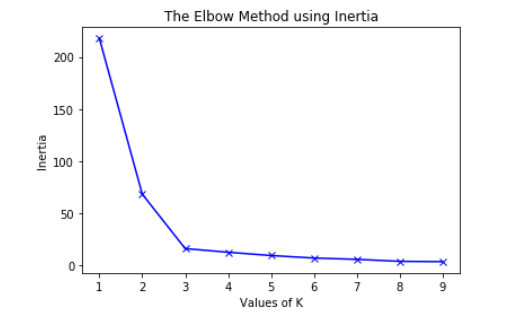
No exemplo acima, o cotovelo da curva se encontra no ponto em que o número de cluster corresponde à 3.<br>
<font color=red>*distorção - mede a distância entre as amostras com relação ao seu cluster<font color=red>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

def _validar_cluster(range_i, range_f, dados_entrada):
    K = range(range_i, range_f)
    wcss = []
    for n_clusters in K:
        clusterer = KMeans(n_clusters=n_clusters, random_state=7, init='k-means++', max_iter=1000)
        preds = clusterer.fit_predict(dados_entrada)
        centers = clusterer.cluster_centers_
        wcss.append(clusterer.inertia_)
    
    chart = sns.lineplot(K, wcss)
    
def _silhouette(n_clusters, dados_entrada):
    clusterer = KMeans(n_clusters=n_clusters, random_state=7, init='k-means++', max_iter=1000)
    preds = clusterer.fit_predict(dados_entrada)
    
    print(f'Silhouette_score: {silhouette_score(dados_entrada, preds)}')

- <strong>Validar modelo<strong>
    
Iremos verificar como se comportam as clusterizações em um range de 2 a 10 clusters.

In [ ]:
_validar_cluster(2, 15, df)

Decidimos por criar o modelo com 6 clusters diferentes, levando em consideração a metodologia do cotovelo conforme citado anteriormente, sendo assim o ponto onde o declínio de performance é perceptível.

In [ ]:
n_clusters = 6
_silhouette(n_clusters, df)

In [ ]:
modelo = KMeans(n_clusters=n_clusters).fit(df)
predicoes = modelo.predict(df)
df['Predições'] = predicoes

- Análise das variáveis vs predição

In [ ]:
plt.figure()
sns.scatterplot(df['Predições'], df['ComprasMes'])
plt.xticks(list(range(0, n_clusters, 1)))
plt.show()

plt.figure()
sns.scatterplot(df['Predições'], df['Capital Social'])
plt.xticks(list(range(0, n_clusters, 1)))
plt.show()

### Ajuste de dados

Utilizei as duas variáveis acima para validar um bom cluster, utilizaremos duas <strong>***********a******************asadassadsdadsd*******asdasd<strong>

Para tentar dar um peso maior às variáveis correspondentes a vendas, decidi por retornar a variável TOTALVENDAS e criar uma nova variável que diz respeito à se o cliente já comprou ou não.

In [ ]:
df = pd.concat([df, total_compras], axis=1)
df['Capital Social'] = df['Capital Social'].apply(lambda x: int(x / 10000) * 1)

df['ClienteComprou'] = df['ComprasMes'].apply(lambda x: 0 if x == 0 else 1)

### Revalidando o modelo

In [ ]:
_validar_cluster(2, 15, df)

In [ ]:
n_clusters = 5
_silhouette(n_clusters, df)

In [ ]:
modelo = KMeans(n_clusters=n_clusters).fit(df)
predicoes = modelo.predict(df)
df['Predições'] = predicoes

plt.figure()
sns.scatterplot(df['Predições'], df['ComprasMes'])
plt.xticks(list(range(0, n_clusters, 1)))
plt.show()

plt.figure()
sns.scatterplot(df['Predições'], df['Capital Social'])
plt.xticks(list(range(0, n_clusters, 1)))
plt.show()

Agora podemos ver claramente uma classificação muito mais forte na variável ComprasMes que antes.

Além disso, foi solicitado que o responsável do setor de vendas verificasse os clusters, se realmente fazia sentido, onde o mesmo retornou com um seguinte feedback positivo.

In [ ]:
pd.concat([pd.read_csv(arquivo, encoding='ISO-8859-1', sep=';')['RAZAOSOCIAL'], df], axis=1).to_excel('teste.xlsx', index=False)